# CNN
> Convolution Neural Network

## Previous Chapter Code

In [1]:
# Download Data
import torch
import numpy as np
from torchvision import datasets

train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True)
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True)

# constant for classes
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot']

x = train_dataset.data
y = train_dataset.targets

# Reshape and cast the input data
x = x.view(-1, 784)
x = x.to(torch.float32)

# Cast the target labels to the 'long' data type
y = y.to(torch.long)

# Split data into train & valid set
from sklearn.model_selection import train_test_split

valid_pct = .2
x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size = valid_pct)

# Normalization
def min_max_scale(data, a=0, b=1):
    # Calculate the minimum and maximum values of the data
    data_min = data.min()
    data_max = data.max()

    # Perform Min-Max Scaling
    data_norm = (data - data_min) / (data_max - data_min)

    # Rescale the data to the [a, b] range
    data_norm = a + data_norm * (b - a)

    return data_norm

x_train_norm = min_max_scale(x_train)
x_valid_norm = min_max_scale(x_valid)

# Load data
from torch.utils.data import TensorDataset, DataLoader

def load_data(x_tensor, y_tensor, batch_size, test):
    data = TensorDataset(x_tensor, y_tensor)

    data_loader = DataLoader(data, batch_size=batch_size, shuffle=not test, drop_last=not test)

    print(f"Total Mini-Batches: {len(data_loader)}")
    for i, (x, y) in enumerate(data_loader):
        if i == 0:
            print(f"Shape of Each Mini-Batch: {x.shape}")
            print("")
            break
    return data_loader

batch_size = 128
train_loader = load_data(x_train_norm, y_train, batch_size=batch_size, test = False)
valid_loader = load_data(x_valid_norm, y_valid, batch_size=batch_size, test=True)

Total Mini-Batches: 375
Shape of Each Mini-Batch: torch.Size([128, 784])

Total Mini-Batches: 94
Shape of Each Mini-Batch: torch.Size([128, 784])



## CNN

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

def calculate_output_size(input_size, kernel_size, padding=0, stride=1):
    output_size = np.floor((input_size - kernel_size + 2 * padding) / stride) + 1
    return int(output_size)

class CustomCNN(nn.Module):
    def __init__(self, dropout_rate):
        super(CustomCNN, self).__init__()

        kernel_size = 3
        padding = 1
        image_size = 28
        num_channels1 = 64
        num_channels2 = 128

        # Calculate the output size after each convolution and pooling
        output_size = calculate_output_size(image_size, kernel_size, padding)
        output_size = int(np.floor(output_size / 2))

        output_size = calculate_output_size(output_size, kernel_size)
        output_size = int(np.floor(output_size / 2))

        input_features = output_size * output_size * num_channels2

        # Convolutional layers with BatchNorm and MaxPool
        self.conv = nn.Sequential(
            nn.Conv2d(1, num_channels1, kernel_size, padding=padding),
            nn.LeakyReLU(),
            nn.BatchNorm2d(num_channels1),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(num_channels1, num_channels2, kernel_size),
            nn.LeakyReLU(),
            nn.BatchNorm2d(num_channels2),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.dropout_rate = dropout_rate
        # Fully connected layers with BatchNorm
        self.fc1 = nn.Linear(input_features, 100)
        self.fc2 = nn.Linear(100, 100)
        self.fc3 = nn.Linear(100, 10)

        self.bn1 = nn.BatchNorm1d(100)

        self.hidden_layers = [self.fc1, self.bn1, self.fc2]

    def forward(self, x):
        x = x.view(-1, 1,28, 28)

        conv = self.conv(x)
        x = conv.flatten(1)
        for layer in self.hidden_layers:
            x = layer(x)
            x = F.relu(x)  # ReLU activation applied after BatchNorm
            x = F.dropout(x, self.dropout_rate, training=self.training)

        output = self.fc3(x)
        return output

# Instantiate the model with a dropout rate
model = CustomCNN(dropout_rate=0.5)

In [3]:
def train_model(model, train_loader, valid_loader, \
                lr, n_epochs, device, weight_decay):

    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay = weight_decay)

    # Lists to store losses and training accuracy
    losses = torch.zeros(n_epochs, len(train_loader))
    train_acc = torch.zeros(n_epochs, len(train_loader))
    valid_acc = torch.zeros(n_epochs, len(valid_loader))

    for epoch in range(n_epochs):
        for i, (x, y) in enumerate(train_loader):

            # Set Model to train mode
            model.train()

            out = model.forward(x.to(device))

            # Calculate loss
            loss = loss_fn(out, y.to(device))

            # Backpropagation
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            # Store the loss
            losses[epoch, i] = loss.item()

            # Calculate training accuracy
            acc = 100 * (out.argmax(1) == y.to(device)).float().mean()
            train_acc[epoch, i] = acc

            # Set Model to evaluation mode
            model.eval()

            # Evaluation on validation data
            with torch.no_grad():
                for j, (x, y) in enumerate(valid_loader):
                    out = model.forward(x.to(device))

                    acc = 100 * (out.argmax(1) == y.to(device)).float().mean()
                    valid_acc[epoch, j] = acc

    return model, losses, train_acc, valid_acc

In [4]:
import time
start_time = time.time()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
n_epochs = 5
droput_rate = .1
weight_decay = .0001
learning_rate = .01

model = CustomCNN(droput_rate).to(device)

parameters, losses, train_acc, valid_acc = train_model(model, \
                                                             train_loader, \
                                                             valid_loader, \
                                                             learning_rate, \
                                                             n_epochs,\
                                                             device, \
                                                             weight_decay)
end_time = time.time()
execution_time = end_time - start_time
execution_time_minutes = int(execution_time // 60)
execution_time_seconds = round(execution_time % 60, 2)
print(f"Model training time: {execution_time_minutes} min {execution_time_seconds}s")

Model training time: 9 min 58.41s


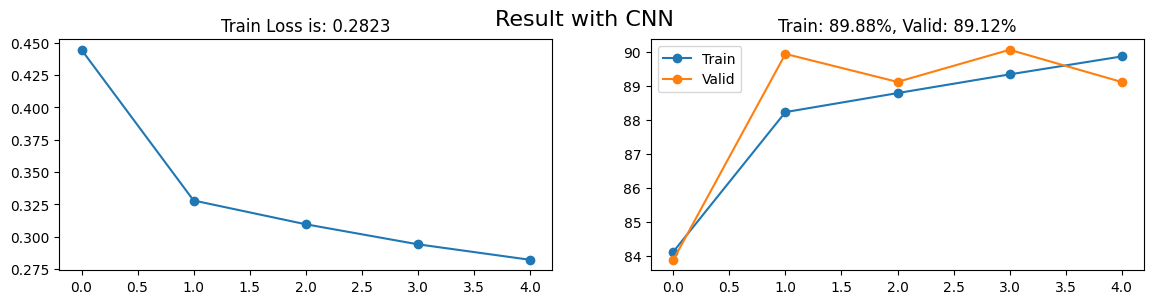

In [5]:
import matplotlib.pyplot as plt

final_loss = losses.mean(1)[-1]
final_train_acc = train_acc.mean(1)[-1]
final_valid_acc = valid_acc.mean(1)[-1]

fig, axs = plt.subplots(1, 2, figsize = (14, 3))

axs[0].plot(range(losses.shape[0]), losses.mean(1), "-o")
axs[0].set_title(f"Train Loss is: {final_loss:.4f}")


axs[1].plot(range(train_acc.shape[0]), train_acc.mean(1), "-o")
axs[1].plot(range(valid_acc.shape[0]), valid_acc.mean(1), "-o")
axs[1].set_title(f"Train: {final_train_acc:.2f}%, Valid: {final_valid_acc:.2f}%")
axs[1].legend(["Train", "Valid"])

plt.suptitle(f"Result with CNN", fontsize = 16)
plt.show()

In [6]:
x_test = test_dataset.data
y_test = test_dataset.targets

# Reshape and cast the input data
x_test = x_test.view(-1, 784)
x_test = x_test.to(torch.float32)
x_test_norm = min_max_scale(x_test)

# Cast the target labels to the 'long' data type
y_test = y_test.to(torch.long)

test_loader = load_data(x_test_norm, y_test, batch_size=batch_size, test=True)

Total Mini-Batches: 79
Shape of Each Mini-Batch: torch.Size([128, 784])



In [7]:
test_acc = []
model.eval()
for i, (x, y) in enumerate(test_loader):
    out = model.forward(x.to(device))

    acc = 100 * (out.argmax(1) == y.to(device)).float().mean()
    test_acc.append(acc.cpu())
model.train()

print(f"Accuracy is: {np.mean(test_acc):.2f}%")

Accuracy is: 87.77%


## Save Model

In [8]:
# Save Model
from google.colab import drive
drive.mount('/content/drive')
model_path = '/content/drive/MyDrive/fnmnist_model.pth'
torch.save(model.state_dict(), model_path)

Mounted at /content/drive


In [9]:
# Load the model
model = CustomCNN(.1)
model.load_state_dict(torch.load('/content/drive/MyDrive/fnmnist_model.pth',  map_location=torch.device('cpu')))

<All keys matched successfully>

In [10]:
test_acc = []
model.to(device)
model.eval()
for i, (x, y) in enumerate(test_loader):
    out = model.forward(x.to(device))

    acc = 100 * (out.argmax(1) == y.to(device)).float().mean()
    test_acc.append(acc.cpu())
model.train()

print(f"Accuracy is: {np.mean(test_acc):.2f}%")

Accuracy is: 87.77%


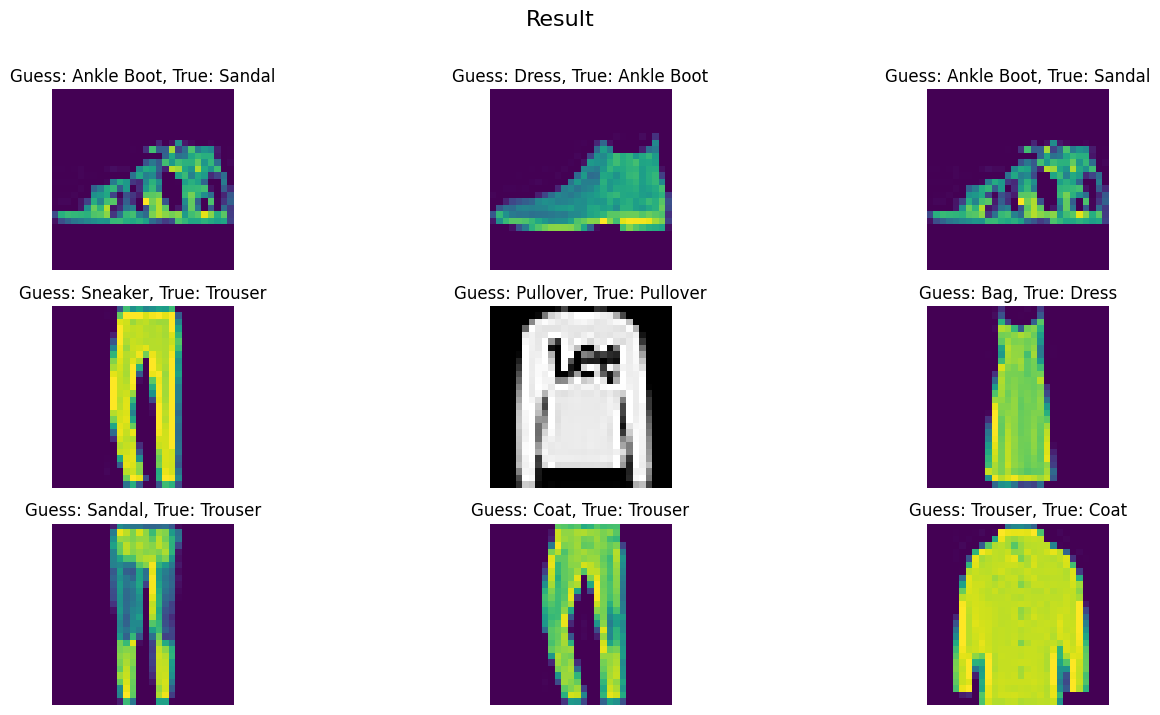

In [11]:
fig, axs = plt.subplots(3, 3, figsize=(16, 8))

for ax in axs.flatten():
    # Select a random index from the output
    random_index = np.random.choice(len(out))

    # Display the image at the selected index with colormap gray for correct predictions
    true_label = y_test[random_index]
    guess_label = out.argmax(1)[random_index]

    if true_label == guess_label:
        ax.imshow(x_test[random_index].view(28, 28), cmap="gray")
    else:
        ax.imshow(x_test[random_index].view(28, 28))


    ax.set_title(f"Guess: {classes[guess_label]}, True: {classes[true_label]}")
    ax.axis("off")

plt.suptitle("Result", fontsize=16)
plt.show()